# This notebook requires DASH Code to run.

It requires `multilayer_convnet.py`: https://github.com/daniel-muthukrishna/astrodash/blob/master/astrodash/multilayer_convnet.py

Additionally, this notebook requires the retrained DASH models, trained ono different spectral resoltuions, which we do not provide.

In [1]:
import sys
import os
import glob

import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt

sys.path.insert(0, "../code")
import abcsn_config

try:
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
except ModuleNotFoundError:
    import tensorflow as tf

from multilayer_convnet import convnet_variables

from icecream import ic

figdir = "./"

2025-07-23 00:04:56.422549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-23 00:04:56.440732: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-23 00:04:56.446297: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-23 00:04:56.461313: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-23 00:04:58.276804: W tensorflow/compiler/tf2

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
MODELS_PATH = "/lustre/lrspec/users/2649/DASH_vs_R/models"
R = 738

R_dir = os.path.join(MODELS_PATH, str(R))
BACKUP_DIR = os.path.join(R_dir, "backup")
training_set_dir = os.path.join(R_dir,  "training_set")
history = pd.read_csv(os.path.join(R_dir, "history.csv"))
MODEL_DIR = BACKUP_DIR

trainLabels = np.load(
    os.path.join(training_set_dir, "trainLabels.npy"),
    mmap_mode="r")
testLabels = np.load(
    os.path.join(training_set_dir, "testLabels.npy"),
    mmap_mode="r")

classes_per_subtype = 18
num_classes = 306
SubTypeIndices = np.arange(0, num_classes + 1, classes_per_subtype)
SubTypeIndices, SubTypeIndices.shape

Ytrn = np.digitize(trainLabels, SubTypeIndices) - 1
Ytst = np.digitize(testLabels, SubTypeIndices) - 1

used_subtypes_trn_int = np.unique(Ytrn)
used_subtypes_tst_int = np.unique(Ytst)

used_subtypes_trn_str = [scs_config.SN_Stypes_int_to_str[SNtype] for SNtype in used_subtypes_trn_int]
used_subtypes_tst_str = [scs_config.SN_Stypes_int_to_str[SNtype] for SNtype in used_subtypes_tst_int]

In [3]:
def get_DASH_results(R, MODELS_PATH):
    R_dir = os.path.join(MODELS_PATH, str(R))
    BACKUP_DIR = os.path.join(R_dir, "backup")
    training_set_dir = os.path.join(R_dir,  "training_set")
    history = pd.read_csv(os.path.join(R_dir, "history.csv"))
    MODEL_DIR = BACKUP_DIR

    trainImages = np.load(
        os.path.join(training_set_dir, "trainImages.npy"),
        mmap_mode="r")
    trainLabels = np.load(
        os.path.join(training_set_dir, "trainLabels.npy"),
        mmap_mode="r")
    trainTypeNames = np.load(
        os.path.join(training_set_dir, "trainTypeNames.npy"),
        mmap_mode="r")

    testImages = np.load(
        os.path.join(training_set_dir, "testImages.npy"),
        mmap_mode="r")
    testLabels = np.load(
        os.path.join(training_set_dir, "testLabels.npy"),
        mmap_mode="r")
    testTypeNames = np.load(
        os.path.join(training_set_dir, "testTypeNames.npy"),
        mmap_mode="r")

    typeNamesList = np.load(
        os.path.join(training_set_dir, "typeNamesList.npy"),
        mmap_mode="r")

    classes_per_subtype = 18
    num_classes = 306
    SubTypeIndices = np.arange(0, num_classes + 1, classes_per_subtype)
    SubTypeIndices, SubTypeIndices.shape

    Ytrn = np.digitize(trainLabels, SubTypeIndices) - 1
    Ytst = np.digitize(testLabels, SubTypeIndices) - 1

    used_subtypes_trn_int = np.unique(Ytrn)
    used_subtypes_tst_int = np.unique(Ytst)

    used_subtypes_trn_str = [scs_config.SN_Stypes_int_to_str[SNtype] for SNtype in used_subtypes_trn_int]
    used_subtypes_tst_str = [scs_config.SN_Stypes_int_to_str[SNtype] for SNtype in used_subtypes_tst_int]

    tf.reset_default_graph()
    nw = len(testImages[0])
    nBins = len(typeNamesList)
    imWidthReduc = 8
    imWidth = 32  # Image size and width
    x, y_, keep_prob, y_conv, W, b = convnet_variables(imWidth, imWidthReduc, nw, nBins)

    saver = tf.train.Saver()
    with tf.Session() as sess:
        index_files = glob.glob(os.path.join(MODEL_DIR, "*.index"))
        latest_ckpt = max(index_files, key=os.path.getctime)
        saver = tf.train.Saver()
        saver.restore(sess, latest_ckpt.split(".index")[0])

        Ptst_typeage_onehot = y_conv.eval(feed_dict={x: testImages, keep_prob: 1.0})
        Ptrn_typeage_onehot = y_conv.eval(feed_dict={x: trainImages, keep_prob: 1.0})

    Ptst_typeage = np.argmax(Ptst_typeage_onehot, axis=1)
    Ptrn_typeage = np.argmax(Ptrn_typeage_onehot, axis=1)

    Ptst = np.digitize(Ptst_typeage, SubTypeIndices) - 1
    Ptrn = np.digitize(Ptrn_typeage, SubTypeIndices) - 1

    performance_tst = calc_metrics(Ytst, Ptst, used_subtypes_tst_int)
    performance_trn = calc_metrics(Ytrn, Ptrn, used_subtypes_trn_int)

    performance_per_class_tst = calc_metrics_per_class(Ytst, Ptst, used_subtypes_tst_int)
    performance_per_class_trn = calc_metrics_per_class(Ytrn, Ptrn, used_subtypes_trn_int)

    return performance_tst, performance_per_class_tst


def calc_metrics_per_class(Y, P, labels):
    cm = sklearn.metrics.confusion_matrix(Y, P, labels=labels)

    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    return FP, FN, TP, TN, TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC


def calc_metrics(Y, P, labels):
    acc = sklearn.metrics.accuracy_score(Y, P)
    f1_macro = sklearn.metrics.f1_score(Y, P, labels=labels, average="macro")
    f1_weighted = sklearn.metrics.f1_score(Y, P, labels=labels, average="weighted")

    precision_macro = sklearn.metrics.precision_score(Y, P, labels=labels, average="macro")
    precision_weighted = sklearn.metrics.precision_score(Y, P, labels=labels, average="weighted")

    recall_macro = sklearn.metrics.recall_score(Y, P, labels=labels, average="macro")
    recall_weighted = sklearn.metrics.recall_score(Y, P, labels=labels, average="weighted")

    return acc, f1_macro, f1_weighted, precision_macro, precision_weighted, recall_macro, recall_weighted

In [4]:
R_arr = [
    6,8,10,12,14,16,18,20,22,24,26,28,30,
    32,34,36,38,40,42,44,46,48,50,55,60,
    65,70,75,80,85,90,95,100,150,200,300,
    400,500,600,700,738,
]
MODELS_PATH = "/lustre/lrspec/users/2649/DASH_vs_R/models"

In [5]:
len(R_arr)

41

In [6]:
all_metrics = []
for R in R_arr:
    performance_tst, performance_per_class_tst = get_DASH_results(R, MODELS_PATH)
    all_metrics.extend([performance_tst, performance_per_class_tst])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/6/backup/model-400


2025-07-23 00:05:01.142789: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/8/backup/model-550
INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/10/backup/model-450
INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/12/backup/model-500
INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/14/backup/model-500
INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/16/backup/model-450
INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/18/backup/model-450


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/20/backup/model-450
INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/22/backup/model-550


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/24/backup/model-550


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/26/backup/model-500


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/28/backup/model-800
INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/30/backup/model-600


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/32/backup/model-450


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/34/backup/model-450


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/36/backup/model-550


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/38/backup/model-500


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/40/backup/model-500
INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/42/backup/model-450


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/44/backup/model-600


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/46/backup/model-550


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/48/backup/model-500


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/50/backup/model-650


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/55/backup/model-500


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/60/backup/model-550


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/65/backup/model-650


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/70/backup/model-600


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/75/backup/model-450


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/80/backup/model-550


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/85/backup/model-500


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/90/backup/model-500


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/95/backup/model-600


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/100/backup/model-550


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/150/backup/model-650


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/200/backup/model-550


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/300/backup/model-550


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/400/backup/model-650


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/500/backup/model-500


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/600/backup/model-600


/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/lrspec/users/2649/miniconda3/envs/fox/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_38151/1387699197.py:91: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/tmp/ipykernel_38151/1387699197.py:99: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/700/backup/model-700
INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/DASH_vs_R/models/738/backup/model-600


In [7]:
# acc, f1_macro, f1_weighted, precision_macro, precision_weighted, recall_macro, recall_weighted
arr_acc = []
arr_f1_macro = []
arr_f1_weighted = []
arr_precision_macro = []
arr_precision_weighted = []
arr_recall_macro = []
arr_recall_weighted = []
for i, R in enumerate(R_arr):
    acc, f1_macro, f1_weighted, precision_macro, precision_weighted, recall_macro, recall_weighted = all_metrics[i*2]
    arr_acc.append(acc)
    arr_f1_macro.append(f1_macro)
    arr_f1_weighted.append(f1_weighted)
    arr_precision_macro.append(precision_macro)
    arr_precision_weighted.append(precision_weighted)
    arr_recall_macro.append(recall_macro)
    arr_recall_weighted.append(recall_weighted)

In [9]:
# FP, FN, TP, TN, TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC
num_classes = 16
arr_FP = np.zeros([num_classes, len(R_arr)])
arr_FN = np.zeros([num_classes, len(R_arr)])
arr_TP = np.zeros([num_classes, len(R_arr)])
arr_TN = np.zeros([num_classes, len(R_arr)])
arr_TPR = np.zeros([num_classes, len(R_arr)])
arr_TNR = np.zeros([num_classes, len(R_arr)])
arr_PPV = np.zeros([num_classes, len(R_arr)])
arr_NPV = np.zeros([num_classes, len(R_arr)])
arr_FPR = np.zeros([num_classes, len(R_arr)])
arr_FNR = np.zeros([num_classes, len(R_arr)])
arr_FDR = np.zeros([num_classes, len(R_arr)])
arr_ACC = np.zeros([num_classes, len(R_arr)])
for i, R in enumerate(R_arr):
    FP, FN, TP, TN, TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC = all_metrics[i*2 + 1]

    arr_FP[:, i] = FP
    arr_FN[:, i] = FN
    arr_TP[:, i] = TP
    arr_TN[:, i] = TN
    arr_TPR[:, i] = TPR
    arr_TNR[:, i] = TNR
    arr_PPV[:, i] = PPV
    arr_NPV[:, i] = NPV
    arr_FPR[:, i] = FPR
    arr_FNR[:, i] = FNR
    arr_FDR[:, i] = FDR
    arr_ACC[:, i] = ACC

In [18]:
# WWW Consider a config file for these
"""Initialize useful dictionaries for SN data."""
SNtypes_str = np.array(
    [
        "Ia-norm",
        "Ia-91T",
        "Ia-91bg",
        "Ia-csm",
        "Iax",
        "Ia-pec",
        "Ib-norm",
        "Ibn",
        "IIb",
        "Ib-pec",
        "Ic-norm",
        "Ic-broad",
        "Ic-pec",
        "IIP",
        "IIL",
        "IIn",
        "II-pec",
    ]
)
SNtypes_int = np.arange(SNtypes_str.size)
SNtypes_str_to_int = {
    SNtype_str: SNtype_int for SNtype_str, SNtype_int in zip(SNtypes_str, SNtypes_int)
}
SNtypes_int_to_str = {j: i for i, j in SNtypes_str_to_int.items()}


SNbroadtypes_str = np.array(["Ia", "Ib", "Ic", "II"])
SNbroadtypes_int = np.arange(SNbroadtypes_str.size)
SNbroadtypes_str_to_int = {
    SNbroadtype_str: SNbroadtype_int
    for SNbroadtype_str, SNbroadtype_int in zip(SNbroadtypes_str, SNbroadtypes_int)
}
SNbroadtypes_int_to_str = {j: i for i, j in SNbroadtypes_str_to_int.items()}


"""Common corrections for SN names"""
SNtypes_str_to_int["Ia-02cx"] = SNtypes_str_to_int["Iax"]
SNtypes_str_to_int["Ia-99aa"] = SNtypes_str_to_int["Ia-91T"]
SNtypes_str_to_int["Ib"] = SNtypes_str_to_int["Ib-norm"]
SNtypes_str_to_int["Ic"] = SNtypes_str_to_int["Ic-norm"]

EXCLUDED_SNTYPES = ["Ia-csm", "Ia-pec", "Ib-pec", "Ic-pec", "IIL", "IIn", "II-pec"]
EXCLUDED_SNTYPES_int = [SNtypes_str_to_int[SNtype_str] for SNtype_str in EXCLUDED_SNTYPES]
EXCLUDED_SNTYPES_int

[3, 5, 9, 12, 14, 15, 16]

In [23]:
good_sntypes = np.array([0, 1, 2, 4, 6, 7, 8, 10, 11, 13])
good_sntypes

array([ 0,  1,  2,  4,  6,  7,  8, 10, 11, 13])

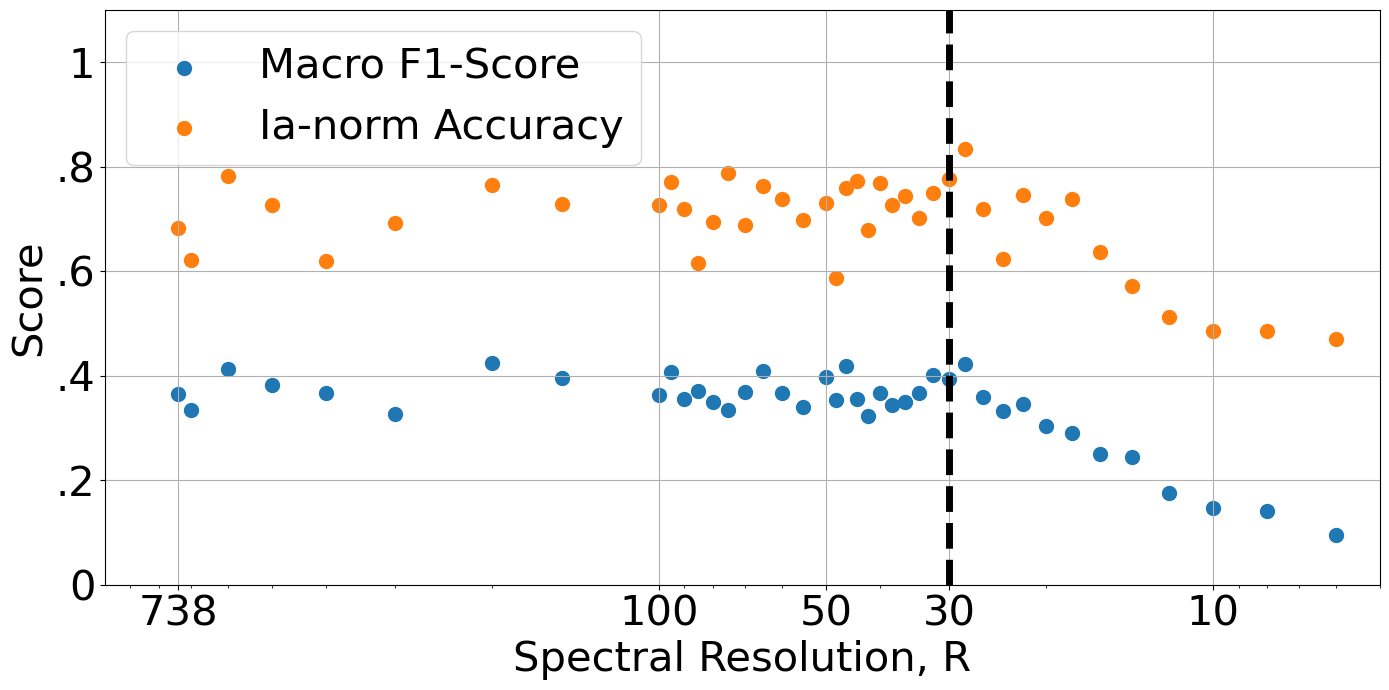

In [33]:
fontsize = 30


fig, ax = plt.subplots(figsize=(14, 7))

ax.set_xscale("log")
ax.grid()

xticks = [738, 100, 50, 30, 10]
ax.set_xticks(ticks=xticks, labels=xticks, size=fontsize)

yticks = [0, 0.20, 0.40, 0.60, 0.80, 1.0]
yticklabels = ["0", ".2", ".4", ".6", ".8", "1"]
ax.set_yticks(ticks=yticks, labels=yticklabels, size=fontsize)

ax.set_xlim((1000, 5))
ax.set_ylim((0, 1.1))

ax.set_xlabel("Spectral Resolution, R", fontsize=fontsize)
ax.set_ylabel("Score", fontsize=fontsize)

ax.axvline(x=30, ls="--", c="k", lw=5)

ax.scatter(R_arr, arr_f1_macro, s=100, color="tab:blue", label="Macro F1-Score")

sntype = "Ia-norm"
ind = np.where(np.array(used_subtypes_tst_str) == sntype)[0][0]
ax.scatter(R_arr, arr_ACC[ind], s=100, color="tab:orange", label=f"{sntype} Accuracy")

ax.legend(loc="upper left", fontsize=fontsize)

plt.tight_layout()
# plt.savefig(os.path.join(figdir, "performance_vs_R.pdf"))
# plt.savefig(os.path.join(figdir, "performance_vs_R.png"))
fig.show()